# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, l2_regularization
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD

In [3]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [5]:
from metrics import mse, r2

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [6]:
class NormalLR:

    def __init__(self):
        self._weights = np.array = None
        self._x = np.array = None
        self._y = np.array = None

        pass

    def fit(self, X:np.ndarray, y:np.ndarray):
        self._x = X.copy()
        self._y = y.copy()
        # a = np.array( [[1 for i in range(X.shape[0])], [1 for i in range(X.shape[1]+1)]] )
        a = np.ones((X.shape[0], X.shape[1] + 1), dtype=X.dtype)
        a[:, :-1] = X
        x_T = np.transpose(a)
        self._weights = np.linalg.inv(x_T @ a) @ x_T @ self._y

        pass
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        a = np.ones((X.shape[0], X.shape[1] + 1), dtype=X.dtype)
        a[:, :-1] = X

        if self._weights is None:
            RuntimeError("Error. regr wasn't fit")
        return a @ self._weights

In [7]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [8]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: (1.8811408840619013, array([ 8.00470746e-04, -3.95894291e-04,  2.39373187e-04,  1.00813190e-03,
        6.35228228e-05,  1.97564934e-05, -7.10354451e-04, -8.47714222e-04,
        4.67542559e-04,  9.03969728e-04, -9.26176004e-04,  3.17367474e-04,
       -1.27116648e-03,  4.94204053e-04, -1.51046087e-03,  1.01720601e-03,
       -9.95078916e-05, -5.45742809e-04,  9.89282928e-05,  3.22200456e-03,
       -6.81325545e-04,  1.47969713e-03,  5.13114853e-04, -5.68861547e-04,
        1.43766699e-04,  2.51075539e-03, -1.67851051e-04, -1.64782425e-04,
       -1.97740481e-03,  9.55764482e-04,  1.47370610e-03, -5.84530075e-04,
        4.88498561e-05,  1.81020385e-03,  8.88638518e-04, -5.11568225e-04,
        6.74613036e-04, -6.72965112e-04,  1.22904340e-03,  1.46211364e-03,
        1.55229066e-03, -4.10710600e-04, -2.23515812e-03,  1.10514569e-03,
       -7.16618447e-04,  6.93815771e-04, -1.44126265e-03,  1.20108233e-03,
       -6.06999951e-04,  1.22000011e-03,  4.33020866e-04,  1.03079036e-03,

### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [7]:
class GradientLR:
    def __init__(self, n_input, n_output, alpha: float, iterations=10000, l=0.):
        self.model = FullyConnectedLayer(n_input=n_input, n_output=n_output);
        self.batch_size = 100
        self.num_epochs = int(iterations / self.batch_size)
        self.alpha = alpha
        self.reg = l

    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!
        for param in self.params():
            self.params()[param].grad = np.zeros_like(self.params()[param].grad);

        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model

        X1 = self.model.forward(X);

        loss, dX1 = mse(y, X1);
        dX = self.model.backward(dX1);

        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        for param in self.params():
            if (param[0] == 'W'):
                loss_, grad_ = l2_regularization(self.params()[param].value, self.reg);
                self.params()[param].grad += grad_;
                loss += loss_;
        return loss

    def fit(self, X: np.ndarray, y: np.ndarray):
        train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, shuffle=True)
        dataset = Dataset(train_X, train_y, val_X, val_y);
        trainer = Trainer(self, dataset, SGD(), accuracy=r2, num_epochs=self.num_epochs,
                          batch_size=self.batch_size, learning_rate=self.alpha, learning_rate_decay=1.0);

        # TODO Implement missing pieces in Trainer.fit function
        # You should expect loss to go down and train and val accuracy go up for every epoch
        loss_history, train_history, val_history = trainer.fit()
        return loss_history, train_history, val_history

    def predict(self, X: np.ndarray):
        return self.model.forward(X)

    def params(self):
        return self.model.params()

In [8]:
def build_plot(train_X, train_y, test_X, test_y):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(train_X.shape[1], train_y.shape[1] if len(train_y.shape) > 1 else 1, 0.1, iterations=10000, l=x)
        regr.fit(train_X, train_y)
        errors.append(mse(test_y, regr.predict(test_X))[0])
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [12]:
X, y = generate_synthetic(1024)
y = np.reshape(y, (len(y), -1))
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [13]:
regr = GradientLR(X_train.shape[1], y_train.shape[1] if len(y_train.shape) > 1 else 1, 0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: (2.0014647887806456, array([[ 6.05089674e-04],
       [-5.22277604e-04],
       [ 5.77439693e-04],
       [ 3.03075834e-04],
       [ 1.30599272e-03],
       [ 3.02758266e-04],
       [ 1.34919699e-03],
       [ 1.70356499e-03],
       [ 9.58841279e-04],
       [ 4.78874566e-05],
       [ 9.38036947e-04],
       [ 1.04177834e-03],
       [-4.88868887e-04],
       [ 1.35244430e-03],
       [ 7.46763712e-04],
       [ 1.00426222e-03],
       [-8.87596381e-04],
       [ 1.83948453e-03],
       [ 7.65259288e-06],
       [ 9.17356709e-04],
       [ 4.81342484e-04],
       [ 7.34131328e-04],
       [ 1.89948283e-03],
       [ 1.56036046e-03],
       [-1.12206744e-03],
       [-9.37914097e-05],
       [ 1.30716288e-03],
       [ 2.42583776e-04],
       [-1.13685794e-03],
       [ 1.75629605e-03],
       [-1.25880128e-03],
       [-1.19985900e-04],
       [-5.90910449e-04],
       [-9.00584219e-04],
       [ 2.03488172e-03],
       [-5.87979568e-04],
       [ 1.13881698e-03],
       [ 2.3

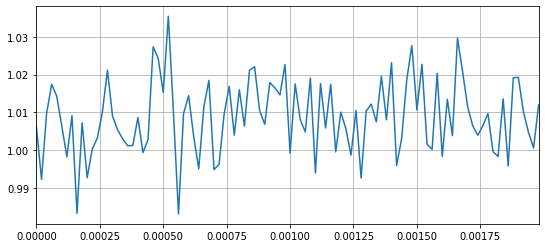

In [14]:
build_plot(X_train, y_train, X_val, y_val)

### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [9]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [ ]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

In [12]:
y_train = np.reshape(y_train, (len(y_train), -1))
y_val = np.reshape(y_val, (len(y_val), -1))

In [ ]:
build_plot(X_train, y_train, X_val, y_val)

In [ ]:
regr = GradientLR(X_train.shape[1], y_train.shape[1] if len(y_train.shape) > 1 else 1, 0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.